In [1]:
import pandas as pd
import errno    
import os
import numpy as np
import math
import pickle

'''
Author: Enrico Ceccolini
    Correspond to an offline power prediction model to be used to predict the mean 
    power consumption, over the execution interval, of a job submitted on the Erurora HPC. 
'''

datadir = "/datasets/eurora_data/db1/"

infile_jobs_to_nodes = datadir + "job_nodes.csv"

suffix = "_5sec_"
### select an interval from
## 1 settings wholeData
#interval_comment_whole = "WholeData"

### select an interval from
## 2 settings Andrea
interval_comment = "Andrea"
start_time = pd.to_datetime('2014-03-31')
end_time = pd.to_datetime('2014-05-01')
#infile_jobs = datadir + "april_long_jobs.csv"

## 3 settings Alina
interval_comment = "Alina"
start_time = pd.to_datetime('2014-03-31')
end_time = pd.to_datetime('2014-11-01')
train_start_time = pd.to_datetime('2014-03-31')
train_end_time = pd.to_datetime('2014-10-01')
test_end_time = pd.to_datetime('2014-11-01')


#infile_jobs = datadir + "CPUs/" + interval_comment + "/" + interval_comment + "_long_jobs_real_pow"
infile_jobs_trainset = datadir + "CPUs/" + interval_comment + "/" + interval_comment + "_trainset"
infile_jobs_testset = datadir + "CPUs/" + interval_comment + "/" + interval_comment + "_testset"

nodes=['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64']

In [2]:
jobs_train = pd.read_csv(infile_jobs_trainset + ".csv", index_col=0)
print("train set contains {} records".format(jobs_train.shape[0]))
jobs_test = pd.read_csv(infile_jobs_testset + ".csv", index_col=0)
print("test set contains {} records".format(jobs_test.shape[0]))

train set contains 146901 records
test set contains 18224 records


In [3]:
jobs_to_nodes_whole_data = pd.read_csv(infile_jobs_to_nodes, index_col=0)
print("jobs_to_nodes_whole_data contains {} records".format(jobs_to_nodes_whole_data.shape[0]))
### clean the data
# remove jobs runned on the inexistent node 129
jobs_to_nodes_whole_data = jobs_to_nodes_whole_data[jobs_to_nodes_whole_data['node_id'] != 129] 
# remove jobs with the same id that runned on the same node
jobs_to_nodes_whole_data = jobs_to_nodes_whole_data.drop_duplicates(subset=['job_id_string', 'node_id'])
print("after the clean, jobs_to_nodes_whole_data contains {} records".format(jobs_to_nodes_whole_data.shape[0]))

jobs_to_nodes_whole_data contains 469095 records
after the clean, jobs_to_nodes_whole_data contains 444610 records


In [4]:
##

#jobs_test = jobs_test[jobs_test['user'] != 'a07smr01']
#print("test set contains {} records".format(jobs_test.shape[0]))

In [5]:
###### NB eseguire solo se non si vogliono job sotto 5 sec

#jobs_test = jobs_test[pd.to_datetime(jobs_test['end_time']) - pd.to_datetime(jobs_test['run_start_time']) > np.timedelta64(5, 's')]
#jobs_test.shape[0]

In [6]:
### merge the info from the two tables
merged_jobs_to_nodes = pd.merge(jobs_test, jobs_to_nodes_whole_data, how='left', on='job_id_string')
print("merged_jobs_to_nodes contains {} records".format(merged_jobs_to_nodes.shape[0]))

merged_jobs_to_nodes contains 18751 records


### select the correct file

### some study of jobs distribution

In [7]:
grouped_jobs_test = merged_jobs_to_nodes.groupby(['user', 'job_name', 'node_id']).size().reset_index(name='counts')

print("{}/{} distinct execution".format(grouped_jobs_test.shape[0], merged_jobs_to_nodes.shape[0]))

16601/18751 distinct execution


In [8]:
grouped_jobs_test = jobs_test.groupby(['user', 'job_name']).size().reset_index(name='counts')
print("{}/{} distinct job names".format(grouped_jobs_test.shape[0], merged_jobs_to_nodes.shape[0]))

6675/18751 distinct job names


In [9]:
# debug
#convlwalle = jobs_test[jobs_test['job_name'] == 'convlwalle'][['real_pow','cpu_req', 'job_name']]
#convlwalle['mean_core'] = convlwalle['real_pow'] / convlwalle['cpu_req']
#convlwalle

In [43]:
''' 1 dataframe
Predict the power consumption of a job.
    If the user and the job name are known, than it use the method 1 [user,job,nodes]
    if only the user is known, than it use the method 2 [user,nodes]
    Otherwise it use the method 3 [nodes]
'''

def predict_pow(user, job_name, used_nodes, used_cpus):
    pred_pow = 0.0
    
    methods = [0, 0, 0, 0, 0]
    
    # check if the method 1 is available
    mean_core_user_job = df_user_job_node.loc[(df_user_job_node['user']==user) & (df_user_job_node['job_name'] == job_name)]
    if(mean_core_user_job.shape[0] != 0):  # if != 0 than user and job name exist on hystoric data
        
        #mean_core_wholeNodes = mean_core_user_job['mean_core'].mean()
        mean_core_wholeNodes = np.average(mean_core_user_job['mean_core'], weights=mean_core_user_job['count'])
        
        for node, ncpu in zip(used_nodes, used_cpus):
            mean_node = mean_core_user_job.loc[(mean_core_user_job['node_id']==node)]
            if(mean_node.shape[0] != 0):
                #pred_pow += mean_node['mean_core'].iloc[0] * ncpu
                pred_pow += mean_node['mean_core'].mean() * ncpu
                methods[0] += 1
            else:
                pred_pow += mean_core_wholeNodes * ncpu
                methods[1] += 1
        return (methods, pred_pow)
    
    
    # check if the method 2 is available
    mean_core_user = df_user_job_node.loc[df_user_job_node['user']==user]
    if(mean_core_user.shape[0] != 0):  # if != 0 than user exists on hystoric data
        
        #mean_core_wholeUserJobs = mean_core_user['mean_core'].mean()
        mean_core_wholeUserJobs = np.average(mean_core_user['mean_core'], weights=mean_core_user['count'])
        
        for node, ncpu in zip(used_nodes, used_cpus):
            mean_node = mean_core_user.loc[(mean_core_user['node_id']==node)]
            if(mean_node.shape[0] != 0):
                #pred_pow += mean_node['mean_core'].iloc[0] * ncpu
                pred_pow += mean_node['mean_core'].mean() * ncpu
                methods[2] += 1
            else:
                pred_pow += mean_core_wholeUserJobs * ncpu
                methods[3] += 1
        return (methods, pred_pow)
    
    
    # method 3 is the only one available
    for node, ncpu in zip(used_nodes, used_cpus):
        mean_node = df_user_job_node.loc[df_user_job_node['node_id']==node]
        mean_core_node = np.average(mean_node['mean_core'], weights=mean_node['count'])
        
        pred_pow += mean_core_node * ncpu
        methods[4] += 1
    return (methods, pred_pow)

### predict with dictionary instead of dataframe

In [11]:
#### NB select the correct file

# ---- whole
infile_user_job_node = datadir + "CPUs/" + interval_comment + "/" + interval_comment + "_mean_core_user_job_node_whole"

with open(infile_user_job_node + ".pkl", 'rb') as handle:
    dict_user_job_node = pickle.load(handle)

In [12]:
dict_user_job_node

{'a07smr01': {'A2REPO': {33: [3.937672265531632, 1.0],
   35: [4.870610861306132, 53.0],
   46: [2.7497916869636483, 21.0],
   7: [12.412155820348273, 1.0],
   'job_node_avg': [4.371550383701862, 76]},
  'ARCHIVE': {7: [11.895912125535574, 1.0],
   'job_node_avg': [11.895912125535574, 1]},
  'ARKI': {33: [5.76609015147425, 7.0],
   35: [4.523224958568197, 77.0],
   46: [4.146008382806946, 26.0],
   'job_node_avg': [4.513156098391378, 110]},
  'INIT': {33: [4.631090150697052, 4.0],
   35: [4.0435601302631525, 68.0],
   37: [23.0829566960988, 1.0],
   46: [4.096130377156768, 20.0],
   48: [4.337865369962934, 1.0],
   51: [59.355148528859424, 1.0],
   'job_node_avg': [4.865105553670937, 95]},
  'LM28_OPE': {1: [23.289646121196803, 1.0],
   2: [23.289646121196803, 1.0],
   33: [19.07357273258673, 2.0],
   34: [21.183719345536712, 5.0],
   35: [21.7961725756327, 5.0],
   36: [19.47714843584208, 13.0],
   37: [24.383610512289337, 70.0],
   38: [22.895262422671642, 42.0],
   40: [24.116235454

In [33]:
''' 1 dictionary
Predict the power consumption of a job.
    If the user and the job name are known, than it use the method 1 [user,job,nodes]
    if only the user is known, than it use the method 2 [user,nodes]
    Otherwise it use the method 3 [nodes]
'''

def predict_pow_dict(user, job_name, used_nodes, used_cpus):
    pred_pow = 0.0
    
    methods = [0, 0, 0, 0, 0]
    
    if(user in dict_user_job_node):
        d_user = dict_user_job_node[user]
        
        if(job_name in d_user):
            d_user_job = d_user[job_name]
            for node_id, ncpu in zip(used_nodes, used_cpus):
                if(node_id in d_user_job): # method 5 - user - job - node
                    pred_pow += d_user_job[node_id][0] * ncpu
                    methods[0] += 1
                else: #  method 4 - user - job
                    pred_pow += d_user_job['job_node_avg'][0] * ncpu
                    methods[1] += 1
        else: # NON ho il job         
            for node_id, ncpu in zip(used_nodes, used_cpus):
                if(node_id in d_user['user_node_avg']): # method 3 - user - node
                    pred_pow += d_user['user_node_avg'][node_id][0] * ncpu
                    methods[2] += 1
                else: # method 2 - user
                    pred_pow += d_user['user_avg'][0] * ncpu
                    methods[3] += 1

    else:  # method 1 - node
        d_nodes = dict_user_job_node['node_avg']
        for node_id, ncpu in zip(used_nodes, used_cpus):
            pred_pow += d_nodes[node_id][0] * ncpu
            methods[4] += 1
    
    return (methods, pred_pow)

In [31]:
# time prediciton
# timing
import time

single_job = jobs_test.head(1000)
single_job = jobs_test

jobs_to_test = []

for index_job_test, row_job_test in single_job.iterrows():
    
    merged_job_to_nodes = merged_jobs_to_nodes[merged_jobs_to_nodes['job_id_string'] == row_job_test['job_id_string']]
    grouped_job_to_nodes = merged_job_to_nodes.groupby(['node_id', 'ncpus','ngpus', 'nmics']).size().reset_index(name='counts')
    
    used_nodes = grouped_job_to_nodes['node_id']
    used_cpus = grouped_job_to_nodes['ncpus']
    
    jobs_to_test.append([row_job_test['user'], row_job_test['job_name'], used_nodes, used_cpus])

In [41]:
start_time = time.time()

global_methods_online = [0, 0, 0, 0, 0]

for job in jobs_to_test:
    methods, predicted_pow = predict_pow_dict(job[0], job[1], job[2], job[3])
    
    if False:
        for j in range(5):
            global_methods_online[j] += methods[j]

print(global_methods_online)
print("--- %s seconds ---" % (time.time() - start_time))

[0, 0, 0, 0, 0]
--- 0.8471484184265137 seconds ---


In [40]:
## OFFLINE 1 FILE
df_user_job_node = df_user_job_node_copy

i = 0
jobs_test['predict_off_whole'] = 0.0
#jobs_test['method_off_whole'] = 0
global_methods = [0, 0, 0, 0, 0]

for index_job_test, row_job_test in jobs_test.iterrows():
    merged_job_to_nodes = merged_jobs_to_nodes[merged_jobs_to_nodes['job_id_string'] == row_job_test['job_id_string']]
    grouped_job_to_nodes = merged_job_to_nodes.groupby(['node_id', 'ncpus','ngpus', 'nmics']).size().reset_index(name='counts')
    
    used_nodes = grouped_job_to_nodes['node_id']
    used_cpus = grouped_job_to_nodes['ncpus']
    
    methods, predicted_pow = predict_pow(row_job_test['user'], row_job_test['job_name'], used_nodes, used_cpus)
    
    for j in range(5):
        global_methods[j] += methods[j]
    
    #print("{}: {} ------- {}".format(method, predicted_pow, row_job_test['real_pow']))
    jobs_test.at[index_job_test, 'predict_off_whole'] = predicted_pow
    #jobs_test.at[index_job_test, 'method_off_whole'] = method
    
    i += 1
    if(i%1000 == 0):
        print("{}/{}".format(i, jobs_test.shape[0]))
    #print("{}/{}".format(i, jobs_test.shape[0]))

df_user_job_node_offline = df_user_job_node

NameError: name 'df_user_job_node_copy' is not defined

In [16]:
global_methods

[1984, 2874, 13841, 46, 6]

In [17]:
jobs_test_copy = jobs_test
#good_quality_jobs = long_jobs[long_jobs['real_pow_quality'] != 0]
#print(math.sqrt(np.var(good_quality_jobs['real_pow'])))
#good_quality_jobs = long_jobs

mean_real_pow = jobs_test['real_pow'].mean()
print("the mean is {}".format(mean_real_pow))

jobs_test['numerator'] = (jobs_test['real_pow'] - jobs_test['predict_off_whole'])**2
jobs_test['denumerator'] = (jobs_test['real_pow'] - mean_real_pow)**2
N = jobs_test['numerator'].shape[0]

r_2 = 1 - (jobs_test['numerator'].sum() / jobs_test['denumerator'].sum())
print("r_2 is {}".format(r_2))

rmse = math.sqrt(jobs_test['numerator'].sum() / N)
print("RMSE is {}".format(rmse))
print("NRMSE is {}".format(rmse/mean_real_pow))

the mean is 75.89084796065079
r_2 is 0.7325718446477507
RMSE is 92.87390321929875
NRMSE is 1.2237826525202833


In [18]:
#debug
df_user_job_node.shape[0]

22730

In [19]:
df_user_job_node_copy.shape[0]

22730

In [48]:
# time prediciton
# timing
import time

timing_job = jobs_test.head(1000)



In [49]:
## ONLINE 1 FILE
df_user_job_node = df_user_job_node_copy
i = 0
jobs_test['predict_online_whole'] = 0.0
#jobs_test['method_off_whole'] = 0
global_methods_online = [0, 0, 0, 0, 0]

start_time = time.time()


for index_job_test, row_job_test in jobs_test.iterrows():
    merged_job_to_nodes = merged_jobs_to_nodes[merged_jobs_to_nodes['job_id_string'] == row_job_test['job_id_string']]
    grouped_job_to_nodes = merged_job_to_nodes.groupby(['node_id', 'ncpus','ngpus', 'nmics']).size().reset_index(name='counts')
    
    used_nodes = grouped_job_to_nodes['node_id']
    used_cpus = grouped_job_to_nodes['ncpus']
    
    methods, predicted_pow = predict_pow(row_job_test['user'], row_job_test['job_name'], used_nodes, used_cpus)
    
    for j in range(5):
        global_methods_online[j] += methods[j]
    
    #print("{}: {} ------- {}".format(method, predicted_pow, row_job_test['real_pow']))
    jobs_test.at[index_job_test, 'predict_online_whole'] = predicted_pow
    #jobs_test.at[index_job_test, 'method_off_whole'] = method
    
    ## ONLINE ---
    for node in used_nodes:
        
        job_node_mean_core = row_job_test['real_pow'] / row_job_test['cpu_req']
        #online_new_row = {'user':row_job_test['user'], 'job_name':row_job_test['job_name'], 'node_id':node, 'count':1, 'mean_core':mean_core}
        #append row to the dataframe
        
        conditions = (df_user_job_node['user'] == row_job_test['user']) & (df_user_job_node['job_name'] == row_job_test['job_name']) & (df_user_job_node['node_id'] == node)
        
        if(conditions.any()):
            ##1 avg between the previous value and the current one
            #df_user_job_node.loc[conditions, ['mean_core', 'count']] = [(df_user_job_node.loc[conditions, 'mean_core'] + mean_core) / 2, df_user_job_node.loc[conditions, 'count'] + 1]
            
            ##2 just place the current one instead the previous (bad results)
            #df_user_job_node.loc[conditions, ['mean_core', 'count']] = [mean_core, df_user_job_node.loc[conditions, 'count'] + 1]
            
            ##3 weighted avg
            prev_mean_core = df_user_job_node.loc[conditions, 'mean_core'].iloc[0]
            prev_count = df_user_job_node.loc[conditions, 'count'].iloc[0]
            df_user_job_node.loc[conditions, ['mean_core', 'count']] = [(prev_mean_core*prev_count + job_node_mean_core) / (prev_count+1), prev_count + 1]
            
        else:
            #print("-------b")
            online_new_row = {'user':row_job_test['user'], 'job_name':row_job_test['job_name'], 'node_id':node, 'count':1, 'mean_core':job_node_mean_core}
            #append row to the dataframe
            df_user_job_node = df_user_job_node.append(online_new_row, ignore_index=True)
        
       
    #df_user_job_node_online = df_user_job_node_online.groupby(['user', 'job_name', 'node_id']).agg({'mean_core':'mean'}).reset_index()
    
    
    #if(i%100 == 0):
    #    break
    
    i += 1
    if(i%1000 == 0):
        print("{}/{}".format(i, jobs_test.shape[0]))
        #break
        
    #print("{}/{}".format(i, jobs_test.shape[0]))

print("--- %s seconds ---" % (time.time() - start_time))
    
df_user_job_node_online = df_user_job_node

1000/18224
2000/18224
3000/18224
4000/18224
5000/18224
6000/18224
7000/18224
8000/18224
9000/18224
10000/18224
11000/18224
12000/18224
13000/18224
14000/18224
15000/18224
16000/18224
17000/18224
18000/18224
--- 700.6041104793549 seconds ---


In [50]:
global_methods_online


[3209, 9708, 5807, 25, 2]

In [51]:
jobs_test_copy = jobs_test
#good_quality_jobs = long_jobs[long_jobs['real_pow_quality'] != 0]
#print(math.sqrt(np.var(good_quality_jobs['real_pow'])))
#good_quality_jobs = long_jobs

mean_real_pow = jobs_test['real_pow'].mean()
print("the mean is {}".format(mean_real_pow))

jobs_test['numerator'] = (jobs_test['real_pow'] - jobs_test['predict_online_whole'])**2
jobs_test['denumerator'] = (jobs_test['real_pow'] - mean_real_pow)**2
N = jobs_test['numerator'].shape[0]

r_2 = 1 - (jobs_test['numerator'].sum() / jobs_test['denumerator'].sum())
print("r_2 is {}".format(r_2))

rmse = math.sqrt(jobs_test['numerator'].sum() / N)
print("RMSE is {}".format(rmse))
print("NRMSE is {}".format(rmse/mean_real_pow))

the mean is 75.89084796065079
r_2 is 0.6887013887042531
RMSE is 100.20253882569912
NRMSE is 1.3203507605772686


In [23]:
##OFFLINE 1
#the mean is 74.0599653418435
#r_2 is 0.6449911853863788
#RMSE is 95.8368082651351
#NRMSE is 1.2940433852861637
#[2758, 3828, 18875, 78, 30]


##ONLINE 1
#the mean is 74.0599653418435
#r_2 is 0.6002694823421173
#RMSE is 101.69425671452096
#NRMSE is 1.3731340035756705
#[4856, 13920, 6751, 34, 8]

# NOTE: only 8 new user

In [24]:
jobs_test.to_csv(infile_jobs_testset + ".csv")

# Print

Code to use when u have the jobs_test['predict_online_whole'] or jobs_test['predict_offline_whole']

In [37]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

def plot_line(data_real, data_approx):
    plt.rcParams['figure.figsize'] = (20,5)

    X_AXIS_NAME = 'datapoints'
    Y_AXIS_NAME = 'Power (W)'
    # TITLE = 'Nodes power consumption - Andrea\'s data'

    fig, ax = plt.subplots()
    ax.xaxis.get_majorticklabels()
    #ax.xaxis.set_major_locator(mdates.DayLocator(interval=days_interval))
    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.tick_params(axis='both', which='major', labelsize=15)

    datapoints = range(0, data_real.shape[0])

    colors = ("orange", "blue")
    
    
    plt.plot(datapoints, data_real, c=colors[1], alpha=1)
    
    plt.plot(datapoints, data_approx, c=colors[0], alpha=0.7)

    #plt.plot(dates, data_real, c=colors[1], alpha=0.6, dashes=[2, 2])
    
    #plt.scatter(dates, node_data['pow_tot_0'] + node_data['pow_tot_1'])

    #fig.autofmt_xdate()
    plt.xlabel(X_AXIS_NAME, fontsize=20)
    plt.ylabel(Y_AXIS_NAME, fontsize=20)
    # plt.title(TITLE)

    # function to show the plot
    plt.show()
    #fig.savefig('graph.png', dpi=fig.dpi)

### offline

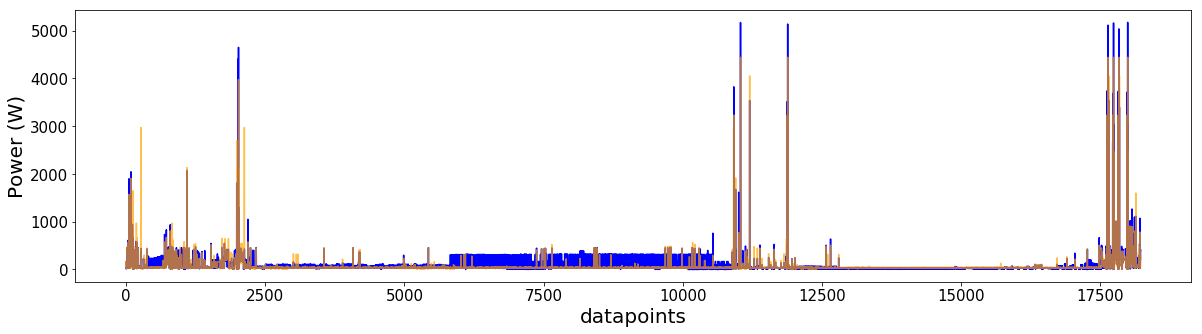

In [38]:
#good_quality_jobs = long_jobs[long_jobs['real_pow_quality'] != 0]
plot_line(data_real=jobs_test['real_pow'], data_approx=jobs_test['predict_off_whole'])

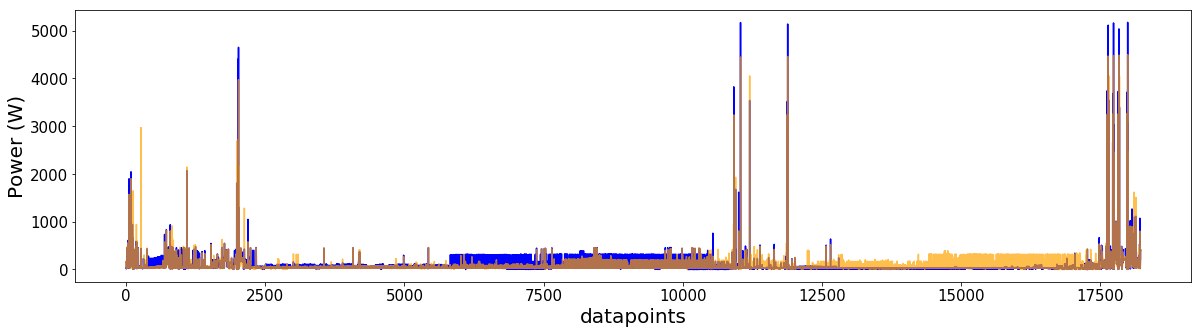

In [39]:
plot_line(data_real=jobs_test['real_pow'], data_approx=jobs_test['predict_online_whole'])

In [40]:
jobs_test.groupby(['job_name']).size().reset_index(name='counts').sort_values('counts', ascending=False)

,job_name,counts
263,convlwalle,198
300,input.job,69
200,S1,61
317,nst.sh,45
208,STDIN,39
301,input_new.job,37
267,cosmomc_nMin20_,35
303,job,31
135,DLP,24
258,a7_wat,24


In [41]:
jobs_test.iloc[15011]

job_id_string               1336080.node129
job_name                         run3159.sh
queue                                 debug
start_time              2014-10-04 09:59:53
run_start_time          2014-10-04 10:00:14
end_time                2014-10-04 10:00:15
user                               asaetti0
node_req                                  1
cpu_req                                   1
mem_req                             4194304
time_req                              00:30
deleted                                 NaN
dependency                              NaN
exit_status                       COMPLETED
pbs_exit_code                           NaN
gpu_req                                   0
mic_req                                   0
real_pow                            8.92863
ran_alone                              True
real_pow_quality                          1
n_2_1                                     0
n_2_2                                     0
n_3_1                           

In [42]:
jobs_test.sort_values('predict_online_whole', ascending=False)

,job_id_string,job_name,queue,start_time,run_start_time,end_time,user,node_req,cpu_req,mem_req,...,n_2_1,n_2_2,n_3_1,job_tot_timepoints,job_timepoints,good_nodes,predict_off_whole,numerator,denumerator,predict_online_whole
job_id,,,,,,,,,,,,,,,,,,,,,
335077,1339668.node129,LM28_OPE,R1297181,2014-10-06 05:18:42,2014-10-06 05:18:46,2014-10-06 06:56:17,a07smr01,12,192,176160768,...,0,0,12,14040,30,12,4443.152624,4.608116e+05,2.600481e+07,4496.551209
334881,1339441.node129,LM28_OPE,R1297180,2014-10-05 17:19:45,2014-10-05 17:19:49,2014-10-05 19:05:14,a07smr01,12,192,176160768,...,0,0,12,15180,47,12,4443.152624,3.017871e+05,2.462596e+07,4488.994309
334751,1339306.node129,LM28_OPE,R1297179,2014-10-05 05:19:40,2014-10-05 05:19:44,2014-10-05 06:58:49,a07smr01,12,192,176160768,...,0,0,12,14268,34,12,4443.152624,4.668777e+05,2.587448e+07,4479.302916
334628,1339173.node129,LM28_OPE,R1297178,2014-10-04 17:20:31,2014-10-04 17:20:36,2014-10-04 19:00:57,a07smr01,12,192,176160768,...,0,0,12,14448,40,12,4443.152624,4.177797e+05,2.540666e+07,4470.034286
328396,1332865.node129,LM28_OPE,R1297177,2014-10-04 05:20:25,2014-10-04 05:20:29,2014-10-04 06:59:53,a07smr01,12,192,176160768,...,0,0,12,14304,40,12,4443.152624,4.622879e+05,2.564538e+07,4460.100481
325850,1330300.node129,LM28_OPE,R1297176,2014-10-03 17:22:26,2014-10-03 17:22:30,2014-10-03 18:59:08,a07smr01,12,192,176160768,...,0,0,12,13908,38,12,4443.152624,5.212573e+05,2.596344e+07,4449.342942
326438,1330890.node129,LM7_TST,R1297176,2014-10-03 18:59:05,2014-10-03 18:59:43,2014-10-03 19:04:32,a07smr01,12,192,176160768,...,0,0,12,684,6,12,4053.341782,2.635762e+05,1.199967e+07,4053.341782
334643,1339188.node129,LM7_TST,R1297178,2014-10-04 19:00:48,2014-10-04 19:01:32,2014-10-04 19:06:26,a07smr01,12,192,176160768,...,0,0,12,696,12,12,4053.341782,2.559152e+05,1.204774e+07,4052.756410
334893,1339454.node129,LM7_TST,R1297180,2014-10-05 19:05:11,2014-10-05 19:06:03,2014-10-05 19:11:28,a07smr01,12,192,176160768,...,0,0,12,780,6,12,4053.341782,4.309290e+05,1.102334e+07,4052.483944


In [43]:
jobs_test[jobs_test['user'] == 'a07smr01']

,job_id_string,job_name,queue,start_time,run_start_time,end_time,user,node_req,cpu_req,mem_req,...,n_2_1,n_2_2,n_3_1,job_tot_timepoints,job_timepoints,good_nodes,predict_off_whole,numerator,denumerator,predict_online_whole
job_id,,,,,,,,,,,,,,,,,,,,,
315736,1318334.node129,INIT,R1315151,2014-10-03 04:00:16,2014-10-03 04:00:16,2014-10-03 07:50:14,a07smr01,1,1,2097152,...,0,0,1,2759,9,1,4.631090,3.895035e-01,5.167289e+03,4.631090
315737,1318335.node129,LM_PRE,R1315151,2014-10-03 04:00:17,2014-10-03 04:00:18,2014-10-03 04:07:55,a07smr01,11,176,161480704,...,0,0,11,1001,14,11,2692.125751,7.770282e+05,3.009333e+06,2692.125751
315740,1318338.node129,LM7_OPE,R1315151,2014-10-03 04:07:46,2014-10-03 04:07:55,2014-10-03 05:07:47,a07smr01,11,176,161480704,...,0,0,11,7898,13,11,1948.703499,1.840656e+06,2.663643e+05,1948.703499
315741,1318339.node129,POSTPROCESS,R1315151,2014-10-03 04:07:48,2014-10-03 04:07:48,2014-10-03 08:16:09,a07smr01,1,8,2097152,...,0,0,1,2980,10,1,46.151113,1.932692e+02,1.904612e+03,46.151113
315742,1318340.node129,ARKI,R1315151,2014-10-03 04:07:49,2014-10-03 04:07:49,2014-10-03 08:16:09,a07smr01,1,1,2097152,...,0,0,1,2980,10,1,5.766090,3.010111e+00,5.163820e+03,5.766090
315743,1318341.node129,TRANSFER1,R1315151,2014-10-03 04:07:50,2014-10-03 04:07:50,2014-10-03 08:16:09,a07smr01,1,1,2097152,...,0,0,1,2979,10,1,5.769784,3.022114e+00,5.163786e+03,5.769784
315744,1318342.node129,TRANSFER2,R1315151,2014-10-03 04:07:51,2014-10-03 04:07:52,2014-10-03 08:16:10,a07smr01,1,1,2097152,...,0,0,1,2979,10,1,5.769697,3.021813e+00,5.163786e+03,5.769697
315746,1318344.node129,WW_SWAN,R1315151,2014-10-03 05:07:44,2014-10-03 05:07:45,2014-10-03 08:16:10,a07smr01,1,1,2097152,...,0,0,1,2261,9,1,5.307388,1.428654e+00,5.152185e+03,5.307388
315748,1318346.node129,A2REPO,R1315151,2014-10-03 05:09:18,2014-10-03 05:09:19,2014-10-03 08:16:10,a07smr01,1,1,2097152,...,0,0,1,2242,9,1,3.937672,3.032170e-02,5.152231e+03,3.937672


In [44]:
import datetime

infile_nodes = datadir + "nodes.csv"

nodes = pd.read_csv(infile_nodes, index_col=0)
#print(nodes.shape[0])

### merge the info from the two tables
merged_jobs_to_nodes = pd.merge(jobs_test, jobs_to_nodes_whole_data, how='left', on='job_id_string')
print("merged_jobs_to_nodes contains {} records".format(merged_jobs_to_nodes.shape[0]))

period = (test_end_time - train_end_time)
period = period.total_seconds() / 5 # total seconds / 5
interval_serie = pd.date_range(train_end_time, periods=period, freq='5s')
frame = { 'timestamp': interval_serie }
all_time_interval_power_consumption = pd.DataFrame(frame)

merged_jobs_to_nodes contains 18751 records


In [45]:
period

535680.0

In [46]:
# set online or off

def calculate_power_consumption(node_str, node_core_idle, interval_size, node_start_time):
    
    # num_minutes = 535680 
    # node_start_time = pd.to_datetime('2014-03-31 00:00:00')
    total_approx_power_consumption = pd.Series(0, index=np.arange(interval_size))
    total_active_cores = pd.Series(0, index=np.arange(interval_size))
    total_real_power_consumption = pd.Series(0, index=np.arange(interval_size))
    
    jobs_to_node = merged_jobs_to_nodes[merged_jobs_to_nodes['node_id'] == int(node_str)]
    #infile_node = datadir + "CPUs/" + interval_comment + "/node" + node_str + suffix + interval_comment + "_active_cores_and_jobs"
    #node_data = pd.read_csv(infile_node + ".csv")
    
    power_consumption_real = pd.Series(0, index=np.arange(interval_size))
    power_consumption_pred = pd.Series(0, index=np.arange(interval_size))
    active_cores = pd.Series(0, index=np.arange(interval_size))
    
    i = 0
    num_jobs = jobs_to_node.shape[0]
    print("{}".format(num_jobs))
    for job_index, job_row in jobs_to_node.iterrows():
        
        #print("{}/{}".format(i, num_jobs))
        i = i + 1
        job_start_time = pd.to_datetime(job_row['run_start_time'])
        job_end_time = pd.to_datetime(job_row['end_time'])
        job_cores = job_row['ncpus']
        job_cores_total = job_row['cpu_req']
        #job_gpus = row['ngpus']
        #job_mics = row['nmics']
        #job_power_consumption_pred = job_row['predict_online_whole'] * (job_cores / job_cores_total) # real_pow contains the total, here we need only the node portion
        job_power_consumption_pred = job_row['predict_off_whole'] * (job_cores / job_cores_total) # real_pow contains the total, here we need only the node portion
        job_power_consumption_real = job_row['real_pow'] * (job_cores / job_cores_total) # real_pow contains the total, here we need only the node portion
        
        
        # print(job_power_consumption_pred)

        before_minutes = int((job_start_time - pd.to_datetime(node_start_time) - np.timedelta64(5, 's')) / np.timedelta64(5, 's'))
        running_minutes = int((job_end_time - job_start_time) / np.timedelta64(5, 's'))
        after_minutes = interval_size - running_minutes - before_minutes

        #pred
        before_serie = pd.Series(0, index=np.arange(before_minutes))
        running_serie = pd.Series(job_power_consumption_pred, index=np.arange(running_minutes))
        after_serie = pd.Series(0, index=np.arange(after_minutes))
        concat_series = pd.concat([before_serie, running_serie, after_serie], ignore_index=True)
        power_consumption_pred = power_consumption_pred.add(concat_series, fill_value=0)
        
        # real
        running_serie = pd.Series(job_power_consumption_real, index=np.arange(running_minutes))
        concat_series = pd.concat([before_serie, running_serie, after_serie], ignore_index=True)
        power_consumption_real = power_consumption_real.add(concat_series, fill_value=0)

        running_serie = pd.Series(job_cores, index=np.arange(running_minutes))
        concat_series = pd.concat([before_serie, running_serie, after_serie], ignore_index=True)
        active_cores = active_cores.add(concat_series, fill_value=0)

        
    #for x in range(0, 17):
    #    # active_cores[active_cores == x] += (node_core_idle * 16) * (16 - x) / 16
    #    active_cores[active_cores == x] += node_core_idle * (16 - x)
    #
    #power_consumption_pred = power_consumption_pred.add(active_cores, fill_value=0)
    #power_consumption_real = power_consumption_real.add(active_cores, fill_value=0)
        
    #indices = node_data['active_cores'] == 0
    #node_data.at[indices, 'pow_tot'] = node_core_idle * 16
    #total_real_power_consumption = node_data['pow_tot']
    
    return power_consumption_real, power_consumption_pred

In [47]:
infile_validate_approx = datadir + "CPUs/" + interval_comment + "/validate_pred_off_" + interval_comment + ".csv"

# per ogni nodo sommo quanto è stato il consumo ad ogni intervallo in un vettore parallelo
# questo sia per il valore approssimato guardando i job
# sia per il valore reale
j = 0
for node_index, node_row in nodes.iterrows():
    node_id = node_row['node_id']
    if( int(node_id) < 10):
        node_id = "0" + str(node_id)
    else:
        node_id = str(node_id)
    print(node_id)
    node_core_idle = node_row['core_idle']
    
    if (node_id != "43"):
        total_real_power_consumption, total_pred_power_consumption = calculate_power_consumption(node_id, node_core_idle, period, train_end_time)
        all_time_interval_power_consumption[node_id + "_real"] = total_real_power_consumption
        all_time_interval_power_consumption[node_id + "_pred"] = total_pred_power_consumption
    
    if(j%10 == 0):
        all_time_interval_power_consumption.to_csv(infile_validate_approx)
all_time_interval_power_consumption.to_csv(infile_validate_approx)

01
45
02
0
03
48
04
37
05
0
06
40
07
75
08
46
09
0
10
40
11
37
12
0
13
34
14
0
15
0
16
0
17
761
18
26
19
38
20
34
21
20
22
0
23
34
24
41
25
43
26
41
27
42
28
30
29
31
30
46
31
56
32
0
33
1829
34
2365
35
1104
36
0
37
240
38
1656
39
7
40
188
41
0
42
141
43
44
1725
45
239
46
226
47
112
48
854
49
81
50
111
51
108
52
0
53
0
54
622
55
502
56
103
57
73
58
77
59
122
60
1224
61
546
62
787
63
1777
64
287


In [48]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

def plot_line(data_dates, data_real, data_approx, days_interval):
    plt.rcParams['figure.figsize'] = (20,5)

    X_AXIS_NAME = 'Time (min)'
    Y_AXIS_NAME = 'Power (W)'
    # TITLE = 'Nodes power consumption - Andrea\'s data'

    fig, ax = plt.subplots()
    ax.xaxis.get_majorticklabels()
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=days_interval))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.tick_params(axis='both', which='major', labelsize=15)

    dates = []
    colors = ("orange", "blue")
    #colors = ("orange", "green")

    for ts in data_dates['timestamp']:
        local_d = datetime.strptime(ts, '%Y-%m-%d %H:%M:%S')
        dates.append(local_d)


    plt.plot(dates, data_real, c=colors[1], alpha=0.5)
    plt.plot(dates, data_real, c=colors[1])
    
    plt.plot(dates, data_approx, c=colors[0], alpha=1)

    #plt.plot(dates, data_real, c=colors[1], alpha=0.6, dashes=[2, 2])
    
    #plt.scatter(dates, node_data['pow_tot_0'] + node_data['pow_tot_1'])

    #fig.autofmt_xdate()
    plt.xlabel(X_AXIS_NAME, fontsize=20)
    plt.ylabel(Y_AXIS_NAME, fontsize=20)
    # plt.title(TITLE)

    # function to show the plot
    plt.show()
    #fig.savefig('graph.png', dpi=fig.dpi)

In [49]:
infile_approximated = datadir + "CPUs/" + interval_comment + "/validate_pred_off_" + interval_comment + ".csv"
#infile_approximated = datadir + "CPUs/" + interval_comment + "/validate_pred_" + interval_comment + ".csv"
predicted_power_consumptions = pd.read_csv(infile_approximated)

#approximated_power_consumption = approximated_power_consumption[pd.to_datetime(approximated_power_consumption['timestamp']) >= pd.to_datetime('2014-03-31 11:21:00')]
#approximated_power_consumption = approximated_power_consumption[pd.to_datetime(approximated_power_consumption['timestamp']) <= pd.to_datetime('2014-04-30 20:32:00')]
#predicted_power_consumptions = predicted_power_consumptions[pd.to_datetime(predicted_power_consumptions['timestamp']) >= pd.to_datetime('2014-10-01 11:21:00')]
predicted_power_consumptions = predicted_power_consumptions[pd.to_datetime(predicted_power_consumptions['timestamp']) <= pd.to_datetime('2014-10-07 18:30:00')]

#approx = approximated_power_consumption.select(lambda col: col.endswith("approx"), axis=1)
real = predicted_power_consumptions.select(lambda col: col.endswith("real"), axis=1)
predicted = predicted_power_consumptions.select(lambda col: col.endswith("pred"), axis=1)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: FutureWarning: 'select' is deprecated and will be removed in a future release. You can use .loc[labels.map(crit)] as a replacement
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:12: FutureWarning: 'select' is deprecated and will be removed in a future release. You can use .loc[labels.map(crit)] as a replacement
  if sys.path[0] == '':


/usr/local/lib/python3.5/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


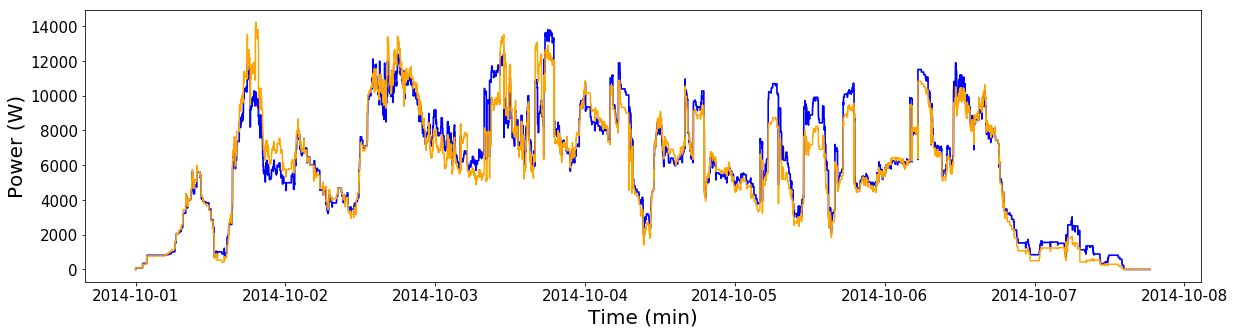

In [50]:
#approx['Total'] = approx.iloc[:, -64:-1].sum(axis=1)
real['Total'] = real.iloc[:, -64:-1].sum(axis=1)
predicted['Total'] = predicted.iloc[:, -64:-1].sum(axis=1)
#differences = approx['Total'] - predicted['Total']
#df = pd.DataFrame(differences)
#df = df.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
#differences_norm = df['Total']

#plot_hist(n_bins=150, data=differences)
#plot_hist(n_bins=150, data=differences_norm)

#plot_line(data_dates=approximated_power_consumption, data_real=real['Total'], data_approx=predicted['Total'], days_interval=5)
plot_line(data_dates=predicted_power_consumptions, data_real=real['Total'], data_approx=predicted['Total'], days_interval=1)

#print("approximation accuracy: {}".format(r2_score(real['Total'], approx['Total'])))